In [378]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import plotly.figure_factory as ff
import plotly, geopandas, shapely
import plotly.io as pio
import sqlite3

pio.renderers

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

# Navigate
os.getcwd()

'/Users/sarasharifzadeh/anaconda3/APROJECTS/projectfiles/ev'

## Objective & Skillset: ##

In this notebook I use a mixture of **`Python` & `SQL`** to analyze EV Charging infrastructure across 50+ CA Counties in 2021. My goal is to assess future charging needs as determined by EV demand, county populations, & analysis of Public & DC Fast charging.  


  #### Tools: `NumPy`, `Pandas`, `SQLite`, `Plotly`, `Seaborn`

#### Project Inspiration: [EV Charging Economics 101, Catalyst](https://medium.com/catalyst-climate/ev-charging-economics-101-f932925beb78) - Darren Hau

### Context

In 2021, the Bipartisan group announced a [large investment in infrastructure](https://www.whitehouse.gov/briefing-room/statements-releases/2021/07/28/fact-sheet-historic-bipartisan-infrastructure-deal/) including $7.5 billion to build out a national network of EV Chargers. 

According to the [CA Energy Commission](https://www.energy.ca.gov/data-reports/energy-almanac/zero-emission-vehicle-and-infrastructure-statistics/new-zev-sales), new Zero-Emission Vehicle Sales in CA (2021) accounted for about 12% of all new cars sold, and in 2022 it was 18.8%.

CA needs to account for the new influx of EV's by developing a robust charging infrastructure in order to support consumer confidence and retention in sustainable transportation alternatives.


### EV Economics & Issues

A few major problems with charging networks today:

* **Most Public charging stations are inefficient & inconvenient:**
    * Level 1 (AC) charge from empty in an average of 11-20 hours
    * Level 2 (AC) charge from empty in an average of 3-8 hours
    
* **While major cities take up a larger share of EV sales, the national renting rate is at
[55.5 percent](https://www.census.gov/quickfacts/fact/table/CA/HSG445221#HSG445221), and they lack home charging opportunties:**
    * City dwellers typically do not have persnal home garages
    * Chargers built into apartment lots are rare & may be used inefficiently (left overnight, few slots)


### The Need for DC Fast 

This points to the need for public (DC) fast stations to offer convenient & accessible charging. According to [Edison Electric Insitute](https://www.eei.org/-/media/Project/EEI/Documents/Issues-and-Policy/Electric-Transportation/EV-Forecast--Infrastructure-Report.pdf) approximately 140,000 DC fast charging (DCFC) ports will be needed to accomodate US Roads in 2030.


<center>
<img alt="chargerdem" src="cdemand.png" width="600px;" />
</center>

source: https://www.mckinsey.com/features/mckinsey-center-for-future-mobility/our-insights/can-public-ev-fast-charging-stations-be-profitable-in-the-united-states

### The Datasets

#### New EV Sales - CA Counties
Zero Emission Vehicles (ZEV) sales are updated on a quarterly basis by examining the DMV Vehicle Registration database for vehicles

**citation:** California Energy Commission (2023). California Energy Commission Zero Emission Vehicle and Infrastructure Statistics. Data last updated [09/30/2023]. Retrieved [11/27/2023] from http://www.energy.ca.gov/zevstats

#### EV Charging  Data - CA Counties
I got this dataset from California Energy Commission (CEC), which was obtained from the Alternative Fuels Data Center Station Locator (AFDC), managed by the National Renewable Energy Laboratory (NREL).

`Public`: Charging data must be reported to the NREL by station operators or developers. Public charging data includes


`Private` :Charger counts are obtained from voluntary surveys issued by the CEC, which are sent to Electric Vehicle Service Providers (EVSP) & Non-EVSPs. Shared private chargers include: workplaces, multi-family housing, fleets, other non-public venues.


**citation:** California Energy Commission (2023). Electric Vehicle Chargers in California. Data last updated [09/16/2023]. Retrieved [11/19/2023] from https://www.energy.ca.gov/zevstats


#### FIPS
Every US state and county has an assigned ID regulated by the US Federal Government under the term FIPS (Federal Information Processing Standards) codes.

`FIPS`: a state FIPS code (eg. 06 for California) with a county FIPS code of the state (eg. 059 for Orange county) and this new state-county FIPS code (06059) uniquely refers to the specified state and county.
**citation:** https://github.com/kjhealy/fips-codes/blob/master/county_fips_master.csv


#### CA County Population Estimates: 

`Population` per County - US Census data for estimates of CA County populations in the year 2021 to determine the "best" counties for EV charging by chargers per 100K people. 


In [379]:
os.getcwd()

'/Users/sarasharifzadeh/anaconda3/APROJECTS/projectfiles/ev'

### EDA - Data Cleaning & Exploration

#### Number of EV Sales per Year

In [380]:
#Visualing CA chargers 

#need fIPS
new_path = '/Users/sarasharifzadeh/anaconda3/APROJECTS/projectfiles/ev'
os.chdir(new_path)

#fips = pd.read_csv("county_fips_master.csv")

#ENCODING ERROR
import chardet

with open('county_fips_master.csv', 'rb') as f:
    result = chardet.detect(f.read())

fips = pd.read_csv('county_fips_master.csv', encoding=result['encoding'])
CAfips = fips[fips['state_abbr']== 'CA']
CAfips = CAfips[["fips", "county_name"]]

CAfips["county_name"] = CAfips["county_name"].str.replace(" County", "")
CAfips.head()

,fips,county_name
187,6001,Alameda
188,6003,Alpine
189,6005,Amador
190,6007,Butte
191,6009,Calaveras


In [381]:
#ZEV SALES DATA 
new_path = '/Users/sarasharifzadeh/anaconda3/APROJECTS/projectfiles/ev'
os.chdir(new_path)

zev = pd.read_csv("zevsales.csv")
zev.head()

,Data Year,County,FUEL_TYPE,MAKE,MODEL,Number of Vehicles
0,1998,Los Angeles,Electric,Ford,Ranger,1
1,1998,Orange,Electric,Ford,Ranger,1
2,1998,San Bernardino,Electric,Ford,Ranger,2
3,1998,San Mateo,Electric,Ford,Ranger,1
4,1999,Santa Barbara,Electric,Ford,Ranger,1


In [382]:
zevf = zev.merge(CAfips, left_on="County", right_on="county_name", how='inner').sort_values("County")
zevf
zevf.groupby(["County", "fips"]).sum("Number of Vehicles").head()

,,Data Year,Number of Vehicles
County,fips,,
Alameda,6001,1155033,117297
Alpine,6003,64654,38
Amador,6005,306958,428
Butte,6007,571512,2118
Calaveras,6009,395832,597


In [383]:
cleanyear = zev.groupby("Data Year").sum("Number of Vehicles")
#sns.lineplot(data=zev, x="Data Year", y="Number of Vehicles")
cleanyear.tail()

,Number of Vehicles
Data Year,
2019,147347
2020,145099
2021,250279
2022,345818
2023,342888


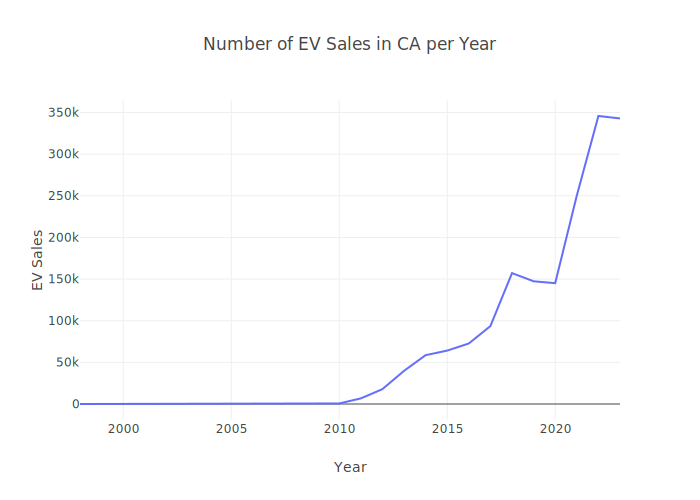

In [386]:
fig = px.line(cleanyear, y='Number of Vehicles', title="Number of EV Sales in CA per Year", 
              labels={'Data Year':'Year', 'Number of Vehicles':'EV Sales'})
fig.layout.template = None
fig.show(renderer="svg")

In [389]:
#cities with most EV's per year
topc = zev.groupby("County").sum("Number of Vehicles").sort_values("Number of Vehicles", ascending=False).reset_index().drop("Data Year", axis=1)
topc
temp = topc.iloc[0:5, 0].to_list()
temp
county5 = zev[zev["County"].isin(temp)]
county510 = county5[(county5["Data Year"] >= 2010)]
county510

county510 = county510.groupby(["County", "Data Year"]).sum("Number of Vehicles").reset_index()

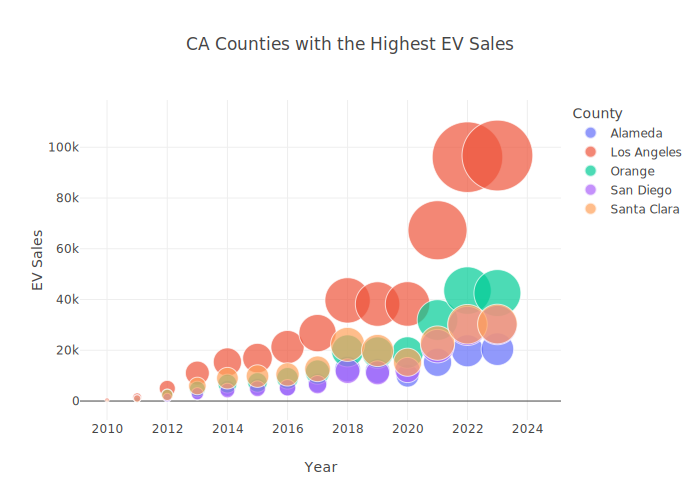

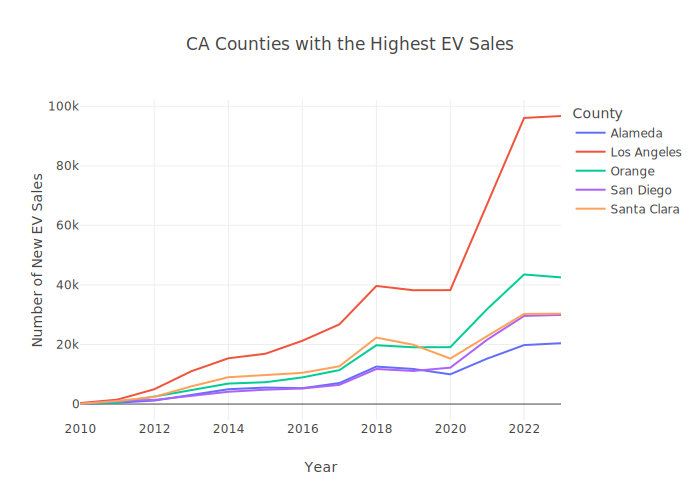

In [391]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=1)

fig = px.scatter(county510, x="Data Year", y="Number of Vehicles",
                 size="Number of Vehicles", color="County",
                labels={'Data Year':'Year', 'Number of Vehicles':'EV Sales'},
                title="CA Counties with the Highest EV Sales",
                log_x=True, size_max=50)

fig.layout.template = None
fig.show(renderer="svg")

fig = px.line(county510, x="Data Year", y="Number of Vehicles",
                color="County",
                labels={'Data Year':'Year', 'Number of Vehicles':'Number of New EV Sales'},
                title="CA Counties with the Highest EV Sales",
                log_x=True)

fig.layout.template = None
fig.show(renderer="svg")

### Moving onto CA Charging Data (2021 only)

In [394]:
#CHARGING DATA 
# the data: quarter1 2021, quarter 2 2021... 
# goal: all quarters for a year in one df with labels for which quarter

#2021 - put all quarters into one df / csv

# ev21 = pd.DataFrame([])

# #read all CSV files and append them to df
# for root, dirs, files in os.walk("."):
#     for name in files:
#         ev_temp = pd.read_csv(name)
#         ev_temp["Quarter"] = name
#         ev21 = pd.concat([ev21,ev_temp])

# # #Save df to a CSV file
# ev21.to_csv('ev2021.csv')

# # #2022
# # ev22 = pd.DataFrame([])

# # #read all CSV files and append them to df
# # for root, dirs, files in os.walk("."):
# #     for name in files:
# #         ev_temp = pd.read_csv(name)
# #         ev_temp["Quarter"] = name
# #         ev22 = pd.concat([ev22,ev_temp])

# # # #Save df to a CSV file
# # ev22.to_csv('ev2022.csv')

new_path = '/Users/sarasharifzadeh/anaconda3/APROJECTS/projectfiles/ev/ev2021'
os.chdir(new_path)

ev21 = pd.read_csv("ev2021.csv")
ev21 = ev21.drop(columns=["Unnamed: 0"])

#changing path
new_path = '/Users/sarasharifzadeh/anaconda3/APROJECTS/projectfiles/ev/ev2022'
os.chdir(new_path)


ev22 = pd.read_csv("ev2022.csv")
ev22 = ev22.drop(columns=["Unnamed: 0"])
ev22
ev21.shape, ev22.shape

((240, 9), (240, 9))

In [395]:
import re
#cleaning the Quarter with regex 
    #currently "q1_22.csv" goal: q1
#https://regex101.com

pattern21 = '(\d\d\d\d.\w\w\w)'
text = 'q12021.csv'

ev21["Quarter"] = ev21["Quarter"].str.replace(pattern21, "", regex=True)
ev21


pattern22 = '(\w\d\d.\w\w\w)'
text = "q3_22.csv"

ev22["Quarter"] = ev22["Quarter"].str.replace(pattern22, "", regex=True)
ev22

ev21.head()

,County,Public Level 1,Shared Private Level 1,Public Level 2,Shared Private Level 2,Public DC Fast,Shared Private DC Fast,Total,Quarter
0,Alameda,6,70,1671,1583,332,35,3697,q4
1,Alpine,0,0,14,0,0,0,14,q4
2,Amador,0,0,25,6,8,0,39,q4
3,Butte,6,0,41,23,24,0,94,q4
4,Calaveras,0,2,7,0,12,0,21,q4


In [396]:
#correct number of County names - 1 per quarter 

ev22 = ev22.sort_values("Quarter")
ev21 = ev21.sort_values("Quarter")

ev21[ev21["County"] == "Alameda"] #checked

#ev22[ev22["County"] == "Alameda"] #checked

,County,Public Level 1,Shared Private Level 1,Public Level 2,Shared Private Level 2,Public DC Fast,Shared Private DC Fast,Total,Quarter
180,Alameda,14,14,1519,1472,296,38,3353,q1
60,Alameda,14,63,1633,1497,310,43,3560,q2
120,Alameda,14,66,1633,1554,315,43,3625,q3
0,Alameda,6,70,1671,1583,332,35,3697,q4


## Exploration

#### Lets Visualize Total EV Chargers per County -- FIPS data

I need to import FIPS Data to map State & County Codes for visualization

In [397]:
ev21["County"] = ev21["County"].astype(str)
CAfips["county_name"] = CAfips["county_name"].astype(str)

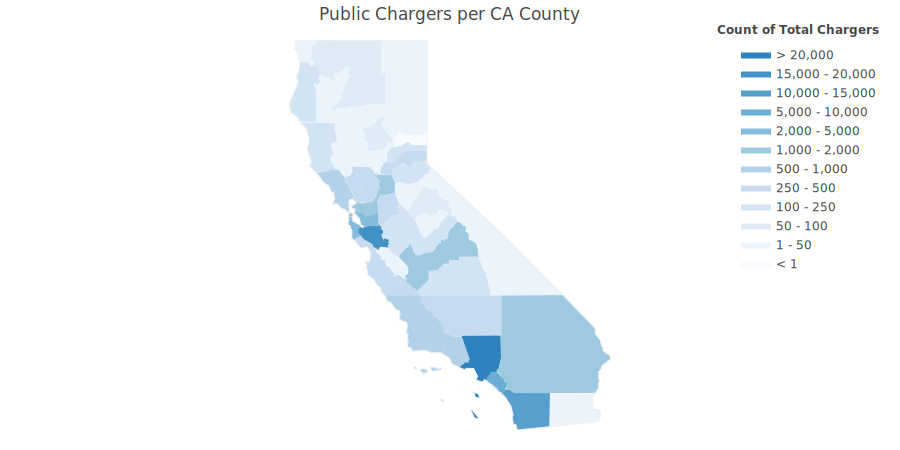

In [398]:
mapev21 = ev21.merge(CAfips, left_on="County", right_on="county_name", how='inner')
mapev21

# NOTE - the data is too uneven to use uniform bins, I intentionally used non-uniform bins

colorscale = ["#f7fbff", "#ebf3fb", "#deebf7", "#d2e3f3", "#c6dbef", "#b3d2e9", "#9ecae1",
    "#85bcdb", "#6baed6", "#57a0ce", "#4292c6", "#3082be", "#2171b5", "#1361a9",
    "#08519c", "#0b4083", "#08306b"
]

#np.logspace(np.log10(0.1),np.log10(1.0), 50)

#endpts = list(np.mgrid[min(values):max(values):16j])
endpts = [1, 50, 100, 250, 500, 1000, 2000, 5000, 10000, 15000, 20000]
values = mapev21['Total'].tolist()
fips = mapev21['fips'].tolist()


fig = ff.create_choropleth(
    fips=fips, values=values, scope=['CA'],
    binning_endpoints=endpts, 
    colorscale=colorscale,
    show_state_data=True,
    show_hover=True,
    asp = 2.9,
    title_text = 'Public Chargers per CA County',
    legend_title = 'Count of Total Chargers'
)
fig.layout.template = None
fig.show(renderer="svg")

**NOTE:** the data is extremely variable. I intentionally used non-uniform bins in this visualization only to aid my understanding. 

## SQL Analysis 

### Public Chargers & DC Fast

In [399]:
#!pip install ipython-sql

In [400]:
# connect library
cnn = sqlite3.connect('tutorial.db')

In [401]:
#load
%reload_ext sql

In [402]:
#renaming columns for SQL
ev21_sql = ev21.rename(columns={"Public Level 1": "pub_l1", "Shared Private Level 1": "priv_l1", "Public Level 2": "pub_l2", "Shared Private Level 2": "priv_l2", "Public DC Fast": "pub_dc", "Shared Private DC Fast":"priv_dc"})
ev21_sql

,County,pub_l1,priv_l1,pub_l2,priv_l2,pub_dc,priv_dc,Total,Quarter
239,Total,326,109,24880,39201,5404,559,70479,q1
206,Monterey,15,0,231,82,93,1,422,q1
205,Mono,0,0,20,0,12,0,32,q1
204,Modoc,0,0,4,0,0,0,4,q1
203,Merced,10,0,52,37,28,3,130,q1
...,...,...,...,...,...,...,...,...,...
34,San Benito,0,0,12,10,25,0,47,q4
33,Sacramento,69,18,825,639,256,6,1813,q4
32,Riverside,3,1,981,186,367,10,1548,q4
30,Placer,0,1,196,106,115,1,419,q4


In [403]:
%sql sqlite:///tutorial.db
    
ev21.to_sql('ev21', cnn)
ev21_sql.to_sql('ev21_sql', cnn)
popmap21.to_sql('popmap21new', cnn)

ValueError: Table 'ev21' already exists.

In [ ]:
%%sql
SELECT * FROM ev21
WHERE County = "Los Angeles"
LIMIT 5;

#### The 5 Counties with the Most EV Chargers in 2021 Q1?

In [ ]:
query_1 = """
SELECT county, total, quarter FROM ev21_sql
WHERE quarter = 'q1'
GROUP BY county
ORDER BY total DESC
LIMIT 5
OFFSET 1;

"""
res_1 = pd.read_sql(query_1, cnn)
res_1

#offset 1 to exclude "total row"
#ev21.groupby("County").sum().sort_values("Total", ascending=False).iloc[1:6, :]#[ev21["County"] != 'Total']

#### The 5 Counties with the most Public EV Chargers in 2021 Q1?

In [ ]:
query_3 = """

SELECT county,  quarter, pub_l1, pub_l2, pub_dc, SUM(pub_l1 + pub_l2 + pub_dc) AS total FROM ev21_sql 
GROUP BY county, quarter
ORDER BY quarter, total DESC
LIMIT 5
OFFSET 1;

"""
res_3 = pd.read_sql(query_3, cnn)
res_3

#### The 5 Counties with the Most DC Fast Chargers in 2021 Q1?

In [ ]:
query_2 = """
SELECT county, quarter, pub_dc, priv_dc, SUM(pub_dc + priv_dc) AS DCtotal FROM ev21_sql
GROUP BY county, quarter
ORDER BY quarter, DCtotal DESC
LIMIT 5
OFFSET 1;

"""
res_2 = pd.read_sql(query_2, cnn)
res_2

#offset 1 to exclude "total row"

#### The 10 Counties with the most Public Chargers overall in 2021?

In [329]:
public21 = ev21[["County", "Public Level 1", "Public Level 2", "Public DC Fast"]]#.sum()
public21["Public Total"] = ev21["Public Level 1"] + ev21["Public Level 2"] + ev21["Public DC Fast"]
public21.groupby("County").sum("Public Total").sort_values("Public Total", ascending=False).iloc[1:6, :]

,Public Level 1,Public Level 2,Public DC Fast,Public Total
County,,,,
Los Angeles,130,28151,3615,31896
Santa Clara,23,14508,2164,16695
Orange,31,10288,1992,12311
San Diego,8,7740,1337,9085
San Mateo,8,7931,1041,8980


#### The 5 Counties with the most Public DC Fast Chargers overall in 2021?

In [337]:
percdc = public21.groupby("County").sum("Public Total")
percdc["percentDCFast"] = percdc["Public DC Fast"]/percdc["Public Total"]
percdc.sort_values("percentDCFast", ascending=False).head()
#public21.groupby("County").sum("Public Total").sort_values("percentDCFast", ascending=False).iloc[1:6, :]

,Public Level 1,Public Level 2,Public DC Fast,Public Total,percentDCFast
County,,,,,
Inyo,0,26,107,133,0.804511
Tehama,0,30,82,112,0.732143
Glenn,0,16,40,56,0.714286
San Benito,0,50,103,153,0.673203
Siskiyou,0,84,168,252,0.666667


These counties have the advantage of being rural with more share of the electricity grid, smaller populations, and less EV owners overall.

#### The percent of DCFC Chargers in Counties with the Highest EV Sales?

In [343]:
percg = percdc.reset_index()
percg[percg["County"].isin(temp)]

,County,Public Level 1,Public Level 2,Public DC Fast,Public Total,percentDCFast
0,Alameda,48,6456,1253,7757,0.161532
18,Los Angeles,130,28151,3615,31896,0.113337
29,Orange,31,10288,1992,12311,0.161807
36,San Diego,8,7740,1337,9085,0.147166
42,Santa Clara,23,14508,2164,16695,0.129620


### Basic Analysis - Public DC Fast Charging in CA

 #### Counties with Highest New EV Sales  & Their Percent of DC Fast Chargers in 2021
 - Los Angeles: 11.33%
 - Santa Clara: 12.96%
 - Orange: 16.18%
 - San Diego: 14.7%
 - Alameda: 16.15%


It seems that Los Angeles, Santa Clara, Orange, San Mateo & San Diego have the most public EV chargers overall in 2021. However, these are majorly comprised of Level 2 chargers and they do not accomodate the need for convenience in counties that require fast charging to accomodate their large population size. **DC Fast charging does not make up 20% of charging stations in any of the 5 Counties in CA with the largest number of EV Sales.**

## What about CA County Population sizes ?

### Chargers By Population - adding CA County population data (2021 only)

In [373]:
#need populations
new_path = '/Users/sarasharifzadeh/anaconda3/APROJECTS/projectfiles/ev'
os.chdir(new_path)


pop = pd.read_csv("capop.csv")
pop = pop.rename(columns={"California": "county", "2021": "population"})
pop
pat = "[^\w ]"
pop["county"] = pop["county"].str.replace(pat, "", regex=True)
pop
popmap21 = mapev21.merge(pop, left_on="County", right_on="county", how="inner")
popmap21
popmap21[popmap21["County"]== "Los Angeles"]

popmap21["population"] = popmap21["population"].apply(lambda a: int(a.replace(',', '')))

popmap21
popmap21["chargers_per_100k"] = (popmap21["Total"].astype(int) / popmap21["population"].astype(int))*100000
# min(popmap21["prop per"]), max(popmap21["prop per"])

# popmap21.sort_values("population", ascending=False).head()

popmap21 = popmap21.drop(columns=["county_name", "county"])
popmap21.sort_values("County").head(5)


,County,Public Level 1,Shared Private Level 1,Public Level 2,Shared Private Level 2,Public DC Fast,Shared Private DC Fast,Total,Quarter,fips,population,chargers_per_100k
103,Alameda,6,70,1671,1583,332,35,3697,q4,6001,1643837,224.900644
100,Alameda,14,14,1519,1472,296,38,3353,q1,6001,1643837,203.973995
102,Alameda,14,66,1633,1554,315,43,3625,q3,6001,1643837,220.520648
101,Alameda,14,63,1633,1497,310,43,3560,q2,6001,1643837,216.566484
96,Alpine,0,0,14,1,0,0,15,q1,6003,1235,1214.574899


### The 5 Counties with the Largest Populations

In [374]:
query_5 = """
SELECT county, population FROM popmap21new
GROUP BY county
ORDER BY population DESC
LIMIT 5
;

"""
res_5 = pd.read_sql(query_5, cnn)
res_5

,County,population
0,Los Angeles,9811842
1,San Diego,3274954
2,Orange,3161005
3,Riverside,2453178
4,San Bernardino,2192882


Note: The data is variable, so I intentionally used non-uniform bins to aid my understanding.

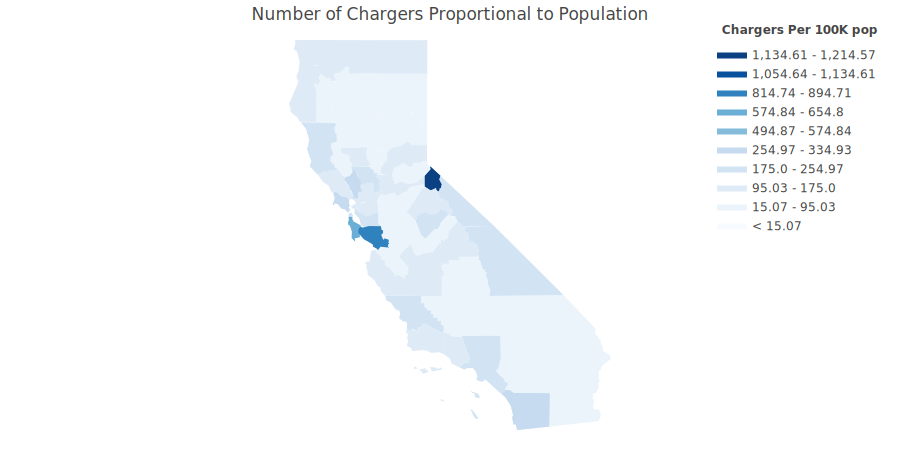

In [375]:
colorscale = ["#f7fbff", "#ebf3fb", "#deebf7", "#d2e3f3", "#c6dbef", "#b3d2e9", "#9ecae1",
    "#85bcdb", "#6baed6", "#57a0ce", "#4292c6", "#3082be", "#2171b5", "#1361a9",
    "#08519c", "#0b4083", "#08306b"
]

values = popmap21['chargers_per_100k'].tolist()
fips = popmap21['fips'].tolist()

#endpts = list(np.mgrid[min(popmap21["prop per"]):max(popmap21["prop per"]):16j])
#np.logspace(np.log10(0.1),np.log10(1.0), 50)

endpts = list(np.mgrid[min(values):max(values):16j])
#endpts = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500]

fig = ff.create_choropleth(
    fips=fips, values=values, scope=['CA'],
    binning_endpoints=endpts, 
    colorscale=colorscale,
    show_state_data=False,
    show_hover=True,
    asp = 2.9,
    title_text = 'Number of Chargers Proportional to Population',
    legend_title = 'Chargers Per 100K pop'
)
fig.layout.template = None
fig.show(renderer="svg")

#### The Best Counties for Charging as determined by Proportion of Chargers

In [376]:
query_4 = """
SELECT county, total AS chargers, population, MAX(chargers_per_100k) AS chargers_per_100k FROM popmap21new
GROUP BY county
ORDER BY chargers_per_100k DESC
LIMIT 5
;

"""
res_4 = pd.read_sql(query_4, cnn)
res_4

,County,chargers,population,chargers_per_100k
0,Alpine,15,1235,1214.574899
1,Santa Clara,16498,1886595,874.485515
2,San Mateo,4701,739060,636.078262
3,San Diego,10080,3274954,307.790583
4,Napa,393,136206,288.533545


### Overall Analysis

* **The 5 Counties with the Highest Number of EV Sales are:** Los Angeles, Orange, Santa Clara, San Diego, & Alameda County.

* **The 5 Counties that appear to be the "best" for EV Charging in 2021 as determined by the proportion of chargers against the population of the county are:** Alpine, Santa Clara, San Mateo, San Diego, & Napa County. 

* **The 5 Counties that appear to be the "best" for EV Charging in 2021 as determined by the proportion of DC Fast chargers against the total amount of Public Chargers:** Inyo, Tehama, Glenn, Benito, & Siskiyou County.

Some of these counties are more rural with smaller populations, like Alpine. Other counties like San Mateo & Santa Clara benefit from smaller total square miles. However, despite having a large population, a county like San Diego has a favorable advantage given the balance between the chargers per square mile. 

From above, we saw that despite Los Angeles, Santa Clara, Orange, San Mateo & San Diego taking up the most share of most public EV chargers overall in 2021, **they do not have enough DC Fast Chargers to accomodate the number of vehicles on the road in 2021:**

***Percent share of DC Fast amongst Public Chargers (2021) in CA County's with Highest EV Sales***
 - Los Angeles: 11.33%
 - Santa Clara: 12.96%
 - Orange: 16.18%
 - San Diego: 14.7%
 - Alameda: 16.15%



Ultimately, the public need more access to quick & convient charging as the demand for EV's rise. In order to accomodate growing demand and support urban communities, charging infrastrucure must adopt more DC Fast Chargers. 